In [10]:
import pandas as pd
import numpy as np
from torch import nn
from torch.utils.data import DataLoader
import timm
from timm import optim
import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn import metrics as skmet
import os
import yaml
import sys

# locally defined
import transforms as my_transforms
from dataset import PdaVideos, collate_video
import models
from utils import num_parameters, EarlyStopper

#set rng seeds
torch.manual_seed(2)
np.random.seed(2)

In [8]:
def evaluate(model, test_dataloader, device):
    model.eval()

    num_steps_per_epoch = len(test_dataloader)

    target_ls = []
    output_ls = []
    losses = []
    for ix, batch in enumerate(test_dataloader):
        inputs = batch['video'].to(device)
        num_frames = batch['num_frames']
        targets = batch['trg_type'].to(device).type(torch.float32)
        target_ls.append(targets.cpu().numpy())
        
        with torch.no_grad():
            outputs, _ = model(inputs, num_frames)
            output_ls.append(outputs.cpu().numpy())
            loss = nn.functional.binary_cross_entropy_with_logits(outputs.squeeze(), targets.squeeze())
            
        losses.append(loss.detach().item())
        
    metrics = compute_metrics(np.concatenate(target_ls), np.concatenate(output_ls))
    return np.mean(losses), metrics

def compute_metrics(y_true, y_pred):
    mets = dict()
    
    y_pred = 1/(1+np.exp(-y_pred))
    y_pred_cls = (y_pred>0.5).astype(int)
    
    mets['roc_auc'] = skmet.roc_auc_score(y_true, y_pred)
    mets['accuracy'] = skmet.accuracy_score(y_true, y_pred_cls)
    mets['sensitivity'] = skmet.recall_score(y_true, y_pred_cls)
    mets['specificity'] = skmet.recall_score(y_true, y_pred_cls, pos_label=0)
    
    return mets

In [53]:
config_file = "/zfs/wficai/pda/model_run_artifacts/pda_numheads_32/config.yaml"

# load config
with open(config_file, 'r') as f:
    cfg = yaml.safe_load(f)
    
cfg['encoder_kwargs']['checkpoint_path'] = None

print("Running training script with configuration:")
print('-'*30)
yaml.dump(cfg, sys.stdout)
print('-'*30)

device = torch.device(cfg['device'])

# classifier network
if cfg['encoder_kwargs']['checkpoint_path'] is not None:
    encoder = timm.create_model(**cfg['encoder_kwargs'], num_classes=cfg['num_pretrain_classes'])
    encoder.fc = nn.Identity()
else:
    encoder = timm.create_model(**cfg['encoder_kwargs'], num_classes=0)
m = models.MedVidNet(encoder, **cfg['vidnet_kwargs']).to(device)

Running training script with configuration:
------------------------------
artifact_folder: /zfs/wficai/pda/model_run_artifacts/pda_numheads_32/
checkpoint_path: null
dataloader_kwargs:
  batch_size: 20
  num_workers: 25
  pin_memory: true
dataset_kwargs:
  mode_filter:
  - color
  - color_compare
  view_filter:
  - pdaRelatedView
  - pdaView
device: cuda:0
early_stopper_kwargs:
  patience: 10
encoder_kwargs:
  checkpoint: null
  checkpoint_path: null
  in_chans: 3
  model_name: resnet50d
  pretrained: true
frame_csv: /zfs/wficai/pda/model_data/pda_train_val_test.csv
num_epochs: 200
optim_kwargs:
  lr: 3.0e-05
  weight_decay: 0.001
res: 112
sched_kwargs:
  factor: 0.1
  patience: 3
  verbose: true
subset_column: null
time_downsample_kwargs:
  method: random
  num_frames: 32
vidnet_kwargs:
  drop_rate: 0.5
  num_heads: 32
  num_out: 1
  pooling_method: attn
------------------------------


In [54]:
def test_on_replica(df_frames):
    num_pars = num_parameters(m)
    num_pars_encoder = num_parameters(encoder)

    # transforms
    tfms = my_transforms.VideoTransforms(cfg['res'], time_downsample_kwargs = cfg['time_downsample_kwargs'])
    tfms_test = tfms.get_transforms('test')

    # create datasets
    d_test = PdaVideos(df_frames, transforms = tfms_test, split='TEST', **cfg['dataset_kwargs'])
    dl_test= DataLoader(d_test, collate_fn=collate_video, **cfg['dataloader_kwargs'])

    m.load_state_dict(torch.load(cfg['artifact_folder'] + 'model_checkpoint_video.ckpt'))

    test_loss, metrics = evaluate(m, dl_test, device)
    
    metrics['num_vids'] = len(d_test)
    return metrics
    
df_frames = pd.read_csv(cfg['frame_csv'])
test_on_replica(df_frames)

{'roc_auc': 0.8234221918432445,
 'accuracy': 0.7573529411764706,
 'sensitivity': 0.7416267942583732,
 'specificity': 0.8095238095238095,
 'num_vids': 272}

In [55]:
def gen_test_replicas(n_patients, n_replicas):
    df_test = df_frames.query('Split=="TEST"')
    df_patients = df_test.groupby('patient_id', as_index=None).size()
    
    for nr in range(n_replicas):
        pids = set(df_patients.sample(n_patients, replace=True).patient_id.to_list())
        df_replica = df_test[df_test.patient_id.isin(pids)]
        
        yield df_replica

In [80]:
N_replicas = 30

all_metrics = []
for n_patients in range(3, 12):
    print(f"Testing for {N_replicas} replicas and {n_patients} patients.")
    for ix, d in enumerate(gen_test_replicas(n_patients, N_replicas)):
        print("Replica:", ix+1)
        try:
            metrics = test_on_replica(d)
        except Exception as e:
            print(e)
            metrics = {'error': e}
        metrics['replica_ix'] = ix
        metrics['num_patients'] = n_patients
        
        all_metrics.append(metrics)

Testing for 30 replicas and 3 patients.
Replica: 1
Replica: 2
Replica: 3
Replica: 4
Replica: 5
Only one class present in y_true. ROC AUC score is not defined in that case.
Replica: 6
Replica: 7
Replica: 8
Replica: 9
Replica: 10
Replica: 11
Replica: 12
Replica: 13
Only one class present in y_true. ROC AUC score is not defined in that case.
Replica: 14
Replica: 15
Replica: 16
Replica: 17
Replica: 18
Replica: 19
Replica: 20
Replica: 21
Replica: 22
Replica: 23
Replica: 24
Replica: 25
Replica: 26
Only one class present in y_true. ROC AUC score is not defined in that case.
Replica: 27
Only one class present in y_true. ROC AUC score is not defined in that case.
Replica: 28
Replica: 29
Replica: 30
Testing for 30 replicas and 4 patients.
Replica: 1
Replica: 2
Replica: 3
Replica: 4
Replica: 5
Replica: 6
Replica: 7
Replica: 8
Replica: 9
Replica: 10
Only one class present in y_true. ROC AUC score is not defined in that case.
Replica: 11
Replica: 12
Replica: 13
Replica: 14
Replica: 15
Replica: 16
R

In [86]:
df_mets = pd.DataFrame(all_metrics).dropna(subset='roc_auc')
df_mets.head()

,roc_auc,accuracy,sensitivity,specificity,num_vids,replica_ix,num_patients,error
0,1.000000,1.000000,1.000000,1.000000,11.0,0,3,NaN
1,0.824719,0.521277,0.494382,1.000000,94.0,1,3,NaN
2,0.950000,0.885246,0.850000,0.952381,61.0,2,3,NaN
3,0.990842,0.958904,0.961538,0.952381,73.0,3,3,NaN
5,0.923148,0.840580,0.866667,0.791667,69.0,5,3,NaN


In [115]:
df_plt = df_mets.groupby('num_patients', as_index=False).apply(lambda x: pd.Series(
    {
        'p_roc': (x['roc_auc']>=0.7).sum()/len(x['roc_auc']), 
        'num_vids': x['num_vids'].sum(),
    }))

df_plt['label'] = df_plt.apply(lambda x: x['num_patients'].astype(str) + x['num_vids'].astype(int).astype(str), axis=1)

df_plt

,num_patients,p_roc,num_vids,label
0,3,1.000000,1899.0,3.01899
1,4,0.777778,2296.0,4.02296
2,5,0.933333,3106.0,5.03106
3,6,0.793103,3286.0,6.03286
4,7,0.933333,4049.0,7.04049
5,8,1.000000,4339.0,8.04339
6,9,0.933333,4589.0,9.04589
7,10,0.966667,4810.0,10.04810
8,11,0.933333,5407.0,11.05407


In [106]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'ROC AUC')

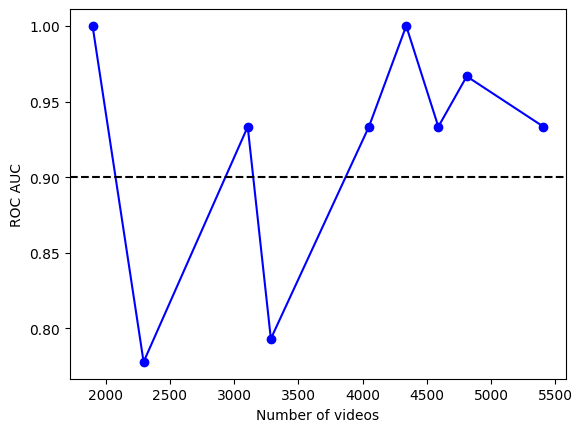

In [109]:
plt.plot(df_plt.num_vids, df_plt.p_roc, 'bo-')
plt.axhline(0.9, color='k', linestyle='--', label='threshold')
plt.xlabel("Number of videos")
plt.ylabel("ROC AUC")

In [95]:
df_mets

,roc_auc,accuracy,sensitivity,specificity,num_vids,replica_ix,num_patients,error
0,1.000000,1.000000,1.000000,1.000000,11.0,0,3,NaN
1,0.824719,0.521277,0.494382,1.000000,94.0,1,3,NaN
2,0.950000,0.885246,0.850000,0.952381,61.0,2,3,NaN
3,0.990842,0.958904,0.961538,0.952381,73.0,3,3,NaN
5,0.923148,0.840580,0.866667,0.791667,69.0,5,3,NaN
...,...,...,...,...,...,...,...,...
265,0.944923,0.888000,0.963855,0.738095,125.0,25,11,NaN
266,0.960604,0.897260,0.963855,0.809524,146.0,26,11,NaN
267,0.959036,0.898551,0.963855,0.800000,138.0,27,11,NaN
268,0.804812,0.712871,0.668790,0.866667,202.0,28,11,NaN
